In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes.solvers import solver
from codes.tb import transforms, utils
from codes.tb.tb import add_tb
from codes.model import Model
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


To simulate infinite systems, we provide the corresponding tight-binding model.

We exemplify this construction by computing the ground state of an infinite spinful chain with onsite interactions.

Because the ground state is an antiferromagnet, so we must build a two-atom cell. We name the two sublattices, $A$ and $B$. The Hamiltonian in is:
$$
H_0 = \sum_i c_{i, B}^{\dagger}c_{i, A} + c_{i, A}^{\dagger}c_{i+1, B} + h.c.
$$
We write down the spinful by simply taking $H_0(k) \otimes \mathbb{1}$.

In [2]:
hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
h_0 = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}

To build the tight-binding model, we need to generate a Hamiltonian on a k-point and the corresponding hopping vectors to generate a guess. We then verify the spectrum and see that the bands indeed consistent of two bands due to the Brillouin zone folding.

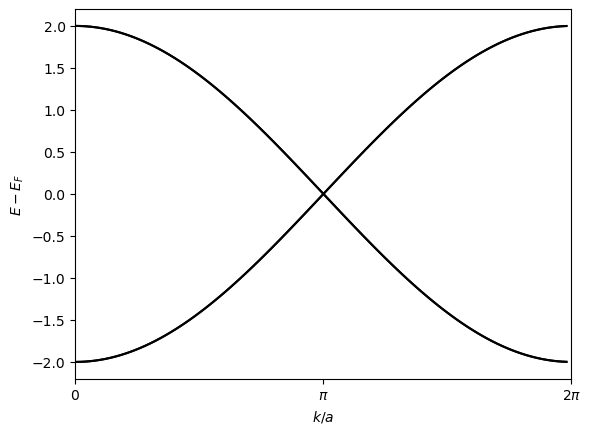

In [4]:
# Set number of k-points
nk = 100
ks = np.linspace(0, 2*np.pi, nk, endpoint=False) 
hamiltonians_0 = transforms.tb_to_khamvector(h_0, nk, 1, ks=ks) 

# Perform diagonalization
vals, vecs = np.linalg.eigh(hamiltonians_0)
# Plot data
plt.plot(ks, vals, c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

Here, in the workflow to find the ground state, we use a helper function to build the initial guess. because we don't need a dense k-point grid in the self-consistent loop, we compute the spectrum later on a denser k-point grid.

Finally, we compute the eigen0alues for a set of Ualues of $U$. For this case, since the interaction is onsite only, the interaction matrix is simply
$$
H_{int} =
\left(\begin{array}{cccc}
    U & U & 0 & 0\\
    U & U & 0 & 0\\
    0 & 0 & U & U\\
    0 & 0 & U & U
\end{array}\right)~.
$$

In [9]:
def compute_phase_diagram(
    Us,
    nk,
    nk_dense,
    filling=2,
):
    gap = []
    vals = []
    for U in tqdm(Us):
        # onsite interactions
        h_int = {
            (0,): U * np.kron(np.ones((2, 2)), np.eye(2)),
            }
        guess = utils.generate_guess(frozenset(h_int), len(list(h_0.values())[0]))
        full_model = Model(h_0, h_int, filling)
        mf_sol = solver(full_model, guess, nk=nk)
        hkfunc = transforms.tb_to_kfunc(add_tb(h_0, mf_sol))
        ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
        hkarray = np.array([hkfunc(kx) for kx in ks_dense])
        _vals = np.linalg.eigvalsh(hkarray)
        _gap = (utils.compute_gap(add_tb(h_0, mf_sol), fermi_energy=0, nk=nk_dense))
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

In [15]:
# Interaction strengths
Us = np.linspace(0.5, 10, 20, endpoint=True)
nk, nk_dense = 40, 100
gap, vals = compute_phase_diagram(Us=Us, nk=nk, nk_dense=nk_dense)

100%|██████████| 20/20 [00:00<00:00, 81.59it/s]


In [16]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(vals=(["Us", "ks", "n"], vals), gap=(["Us"], gap)),
    coords=dict(
        Us=Us,
        ks=np.linspace(0, 2 * np.pi, nk_dense),
        n=np.arange(vals.shape[-1])
    ),
)


We observe that as the interaction strength increases, a gap opens due to the antiferromagnetic ordering.

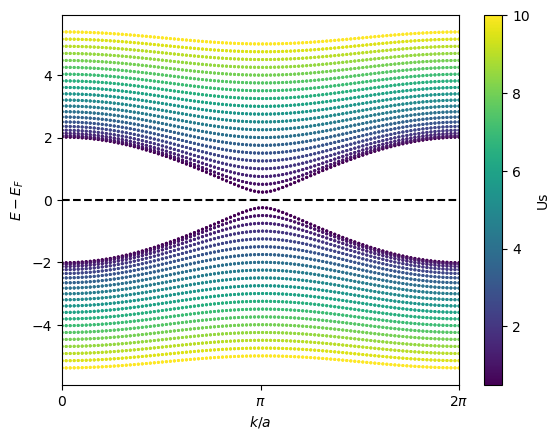

In [17]:
ds.vals.plot.scatter(x="ks", hue="Us", ec=None, s=5)
plt.axhline(0, ls="--", c="k")
plt.xticks([0, np.pi, 2 * np.pi], ["$0$", "$\pi$", "$2\pi$"])
plt.xlim(0, 2 * np.pi)
plt.ylabel("$E - E_F$")
plt.xlabel("$k / a$")
plt.show()

The Hartree-Fock dispersion should follow (see [these notes](https://www.cond-mat.de/events/correl11/manuscript/Lechermann.pdf))
$$
\epsilon_{HF}^{\sigma}(\mathbf{k}) = \epsilon(\mathbf{k}) + U \left(\frac{n}{2} + \sigma m\right)
$$
where $m=(\langle n_{i\uparrow} \rangle - \langle n_{i\downarrow} \rangle) / 2$ is the magnetization per atom and $n = \sum_i \langle n_i \rangle$ is the total number of atoms per cell. Thus, for the antiferromagnetic groundstate, $m=1/2$ and $n=2$. The gap thus should be $\Delta=U$. And we can confirm it indeed follows the expected trend.

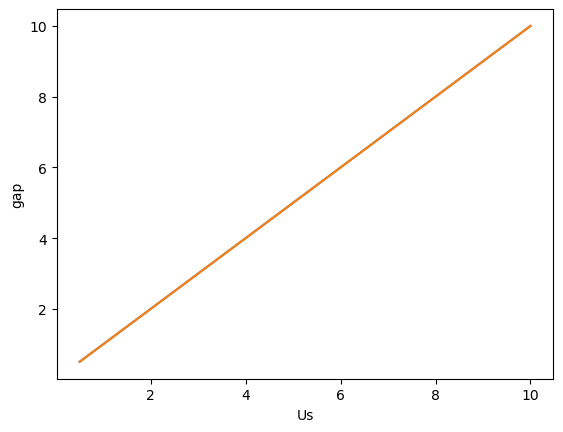

In [18]:
ds.gap.plot()
plt.plot(ds.Us, ds.Us)
plt.show()

We can also fit 

In [19]:
ds.gap.polyfit(dim="Us", deg=1).polyfit_coefficients[0].data

array(0.9997852)

In [20]:
ds.to_netcdf("./data/1d_hubbard_example.nc")